In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from bs_fdbck.util.BSOA_datamanip.ec_earth import (rename_ifs_vars,
                                                   fix_units_ec_earth, 
                                                   fix_timestamp_ec_earth,
                                                   change_units_and_compute_vars_ec_earth
                                                  )

In [134]:
f ='/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/tmp/IFS_GG+201206_IFS_ATTO_tmp_subset.nc'



In [148]:
f2 ='/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/tmp/IFS_GG+201206_IFS_SMR_tmp_subset.nc'


In [166]:
ds_2 = xr.open_dataset(f2)
ds_2

<xarray.Dataset>
Dimensions:  (nhyi: 92, nhym: 91, lat: 8, lev: 91, lon: 11, plev: 11, time: 240)
Coordinates:
  * lat      (lat) float32 65.61 64.91 64.21 63.51 62.81 62.11 61.4 60.7
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 87.0 88.0 89.0 90.0 91.0
  * lon      (lon) float32 22.5 23.2 23.91 24.61 ... 27.42 28.12 28.83 29.53
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time     (time) datetime64[ns] 2012-06-01T03:00:00 ... 2012-07-01
Dimensions without coordinates: nhyi, nhym
Data variables: (12/31)
    hyai     (nhyi) float64 ...
    hyam     (nhym) float64 ...
    hybi     (nhyi) float64 ...
    hybm     (nhym) float64 ...
    var130   (time, plev, lat, lon) float32 ...
    var131   (time, plev, lat, lon) float32 ...
    ...       ...
    var72    (time, lat, lon) float32 ...
    var73    (time, lat, lon) float32 ...
    var74    (time, lat, lon) float32 ...
    var75    (time, lat, lon) float32 ...
    var78    (time, lat, lon) float32 ...
    var79    (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Dec 19 22:19:45 2022: ncks -O -d lon,22.0,30.0 -d lat,6...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [172]:
ds_in = xr.open_dataset(f)

In [173]:
60*60*3

10800

In [174]:
10800/60/60/3

1.0

In [175]:
ds=rename_ifs_vars(ds_in)
ds2=rename_ifs_vars(ds_2)

#ds = ds.rename({'CDNC':'cdnc'})

renaming var130 to temp
renaming var131 to U
renaming var132 to V
renaming var136 to tcw
renaming var137 to tcwv
renaming var164 to ttc
renaming var176 to surf_net_srad
renaming var177 to surf_net_lrad
renaming var178 to toa_net_srad
renaming var179 to toa_net_lrad
renaming var20 to cdnc
renaming var208 to toa_net_srad_clear
renaming var21 to re_liq
renaming var210 to surf_net_srad_clear
renaming var211 to sur_net_lrad_clear
renaming var22 to liq_cloud_time
renaming var248 to cc
renaming var68 to toa_net_srad_clearclean
renaming var69 to toa_net_srad_clean
renaming var70 to surf_net_srad_clearclean
renaming var71 to surf_net_srad_clean
renaming var72 to toa_net_lrad_clearclean
renaming var73 to toa_net_lrad_clean
renaming var74 to surf_net_lrad_clearclean
renaming var75 to surf_net_lrad_clean
renaming var78 to tclw
renaming var79 to tciw
renaming var130 to temp
renaming var131 to U
renaming var132 to V
renaming var136 to tcw
renaming var137 to tcwv
renaming var164 to ttc
renaming var17

In [176]:
def make_dummy_lev(ds):
    if 'lev_orig' not in ds.coords:
        ds = ds.rename({'lev':'lev_orig'})
        #ds = ds.rename(lev=
        ds['lev'] = (1e-2*(ds['hyam'] + ds['hybm']*1e5)).swap_dims({'nhym':'lev_orig'})
        ds = ds.swap_dims({'lev_orig':'lev'})
    return ds

In [177]:
ds = make_dummy_lev(ds)
ds2 = make_dummy_lev(ds2)

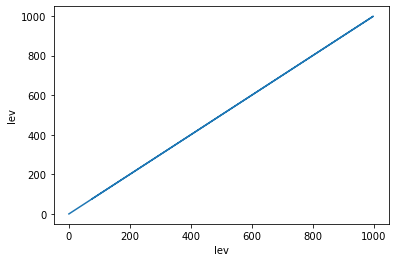

In [178]:
ds['lev'].isel(lev=[1,5,6,7,80,90, 34]).plot()

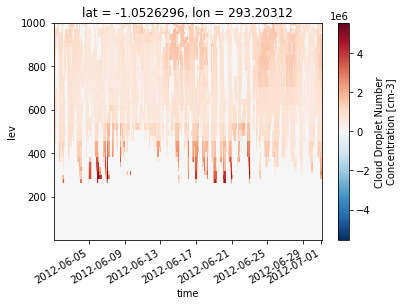

In [179]:
ds['cdnc'].isel(lat=0,lon=0).plot(x='time')

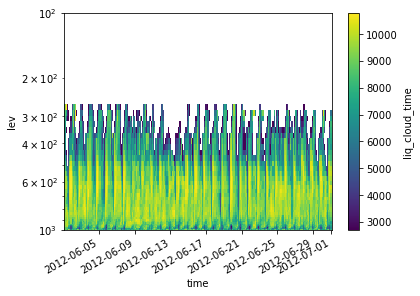

In [180]:
ds['liq_cloud_time'].where(ds['liq_cloud_time']>0).mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log',)

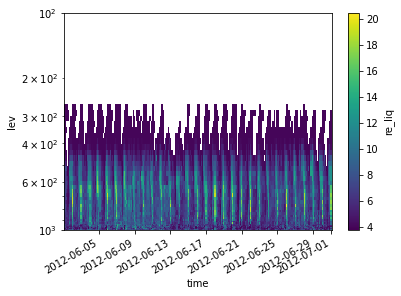

In [181]:
ds['re_liq'].where(ds['liq_cloud_time']>0).mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log',)

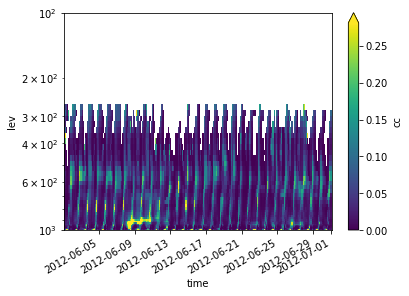

In [184]:
ds['cc'].where(ds['liq_cloud_time']>0).mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log',robust=True)

In [188]:
def extract_cloud_top(ds):
    if 'lev_orig' not in ds.coords:
        ds = make_dummy_lev(ds)
    ds = ds.sortby('lev', ascending=False)
    ds['cloud_time_norm'] = ds['liq_cloud_time'] / sec_in_timestep

    ds['cumsum'] = (ds['cl_frac_where_cltime_pos']
                    .fillna(0)
                    .where(ds['cl_time_liq_norm'] > 0)
                    .cumsum('lev')
                    .where(ds['cl_frac_where_cltime_pos'] > 0.2)
                    .where(ds['cloud_time_norm'] == 1.)
                    )  #
    #ds['cumsum'] = ds['cumsum'].where(np.abs(ds['re_liq']-4) > 0.01)

    ds['argmax'] = ds['cumsum'].fillna(0).argmax('lev', )

    ds['cdnc_incld_cltop'] = ds['cdnc_incld'].isel(lev=ds['argmax']).where(ds['argmax'] > 0)
    ds['re_liq_incld_cltop'] = ds['re_liq_incld'].isel(lev=ds['argmax']).where(ds['argmax'] > 0)

    ds['re_liq_cltop'] = (ds['re_liq']
                          .where(ds['argmax'] > 0)
                          .where(ds['cl_frac_where_cltime_pos'] > 0)
                          .where(ds['liq_cloud_time'] > 0)
                          .isel(lev=ds['argmax'])
                          )
    ds['cc_cltop'] = ds['cc_all'].isel(lev=ds['argmax']).where(ds['argmax'] > 0)

    ds = ds.sortby('lev', ascending=True)
    ds['argmax'] = -ds['argmax'] - 1

    return ds

def calculate_incld_values_warmclouds(ds):
    # 3 hourly data:
    sec_in_timestep = (3 * 60 * 60)
    re_ex = ('re_liq' in ds.data_vars)
    liq_cloud_time_ex = ('liq_cloud_time' in ds.data_vars)
    cdnc_incld_ex = ('cdnc' in ds.data_vars)
    tciw_ex = ('tciw' in ds.data_vars)
    tclw_ex = ('tclw' in ds.data_vars)
    ttc_ex = ('ttc' in ds.data_vars)
    cc_ex = ('cc' in ds.data_vars)
    if (re_ex and liq_cloud_time_ex):
        print('calculating re_liq_incld')
        ds['re_liq_incld'] = ((ds['re_liq'] / ds['liq_cloud_time'])
                              .where(ds['liq_cloud_time'] > 0)
                              .where(ds['re_liq'] > 0)
                              * sec_in_timestep
                              )
    if (cdnc_incld_ex and liq_cloud_time_ex):
        print('calculating cdnc_incld')
        ds['cdnc_incld'] = ((ds['cdnc'] / ds['liq_cloud_time'])
                            .where(ds['liq_cloud_time'] > 0)
                            .where(ds['cdnc'] > 0)
                            # *(60*60*3)
                            )
    if liq_cloud_time_ex:
        print('calculating cl_time_liq_norm')
        ds['cl_time_liq_norm'] = ds['liq_cloud_time'].where(ds['liq_cloud_time'] > 0) / 10800
    if 'cc' in ds.data_vars:
        print('Calulating cc_all')
        ds['cc_all'] = ds['cc'].where(ds['cc'] > 0)
    if tciw_ex and tclw_ex:
        print('Calulating liq_frac_cwp')

        ds['liq_frac_cwp'] = ds['tclw'] / (ds['tclw'] + ds['tciw'])
    if cc_ex and liq_cloud_time_ex:
        print('calculating cl_frac_where_cltime_post')
        ds['cl_frac_where_cltime_pos'] = ds['cc_all'].where(ds['cl_time_liq_norm'] > 0)
    if ttc_ex and tclw_ex:
        print('calculating cwp_incld')
        ds['cwp_incld'] = ds['tclw'] / ds['ttc']
    return ds


In [190]:
ds2 = calculate_incld_values_warmclouds(ds2)
ds2 = extract_cloud_top(ds2)

calculating re_liq_incld
calculating cdnc_incld
calculating cl_time_liq_norm
Calulating cc_all
Calulating liq_frac_cwp
calculating cl_frac_where_cltime_post
calculating cwp_incld


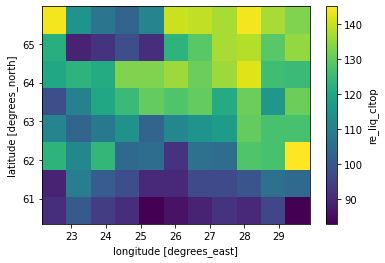

In [192]:
ds2['re_liq_cltop'].count('time').plot()

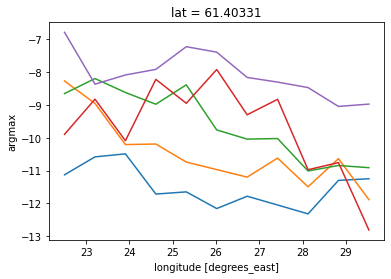

In [200]:
ds2['argmax'].isel(lat=2).mean('time').plot()

ds2['argmax'].isel(lat=3).mean('time').plot()
ds2['argmax'].isel(lat=4).mean('time').plot()
ds2['argmax'].isel(lat=5).mean('time').plot()
ds2['argmax'].isel(lat=6).mean('time').plot()

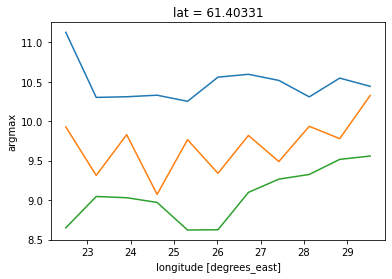

In [213]:
ds2['argmax'].isel(lat=2).std('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['argmax'].isel(lat=5).std('time').plot()
ds2['argmax'].isel(lat=6).std('time').plot()

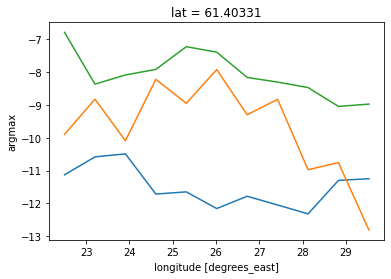

In [214]:
ds2['argmax'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['argmax'].isel(lat=5).mean('time').plot()
ds2['argmax'].isel(lat=6).mean('time').plot()

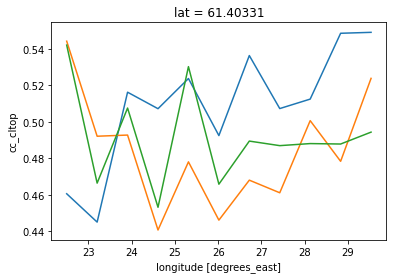

In [215]:
ds2['cc_cltop'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['cc_cltop'].isel(lat=5).mean('time').plot()
ds2['cc_cltop'].isel(lat=6).mean('time').plot()

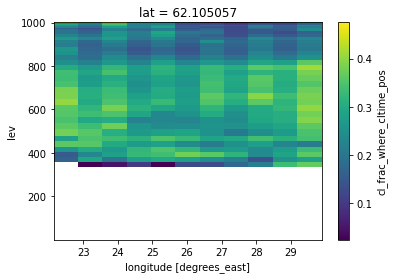

In [217]:
#ds2['cl_frac_where_cltime_pos'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['cl_frac_where_cltime_pos'].isel(lat=5).mean('time').plot()
#ds2['cl_frac_where_cltime_pos'].isel(lat=6).mean('time').plot()

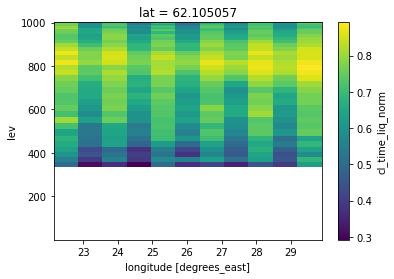

In [233]:
#ds2['cl_frac_where_cltime_pos'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['cl_time_liq_norm'].isel(lat=5).mean('time').plot()
#ds2['cl_frac_where_cltime_pos'].isel(lat=6).mean('time').plot()

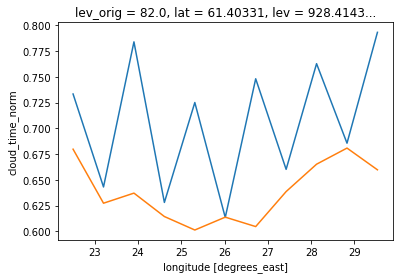

In [247]:
#ds2['cl_frac_where_cltime_pos'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['cloud_time_norm'].where(ds2['liq_cloud_time'] > 0).isel(lat=5, lev=-10).mean('time').plot()
ds2['cloud_time_norm'].where(ds2['liq_cloud_time'] > 0).isel(lat=6, lev=-10).mean('time').plot()

#ds2['cl_frac_where_cltime_pos'].isel(lat=6).mean('time').plot()

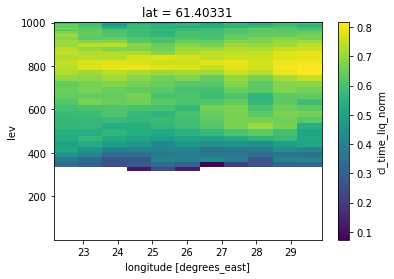

In [234]:
#ds2['cl_frac_where_cltime_pos'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
ds2['cl_time_liq_norm'].isel(lat=6).mean('time').plot()
#ds2['cl_frac_where_cltime_pos'].isel(lat=6).mean('time').plot()

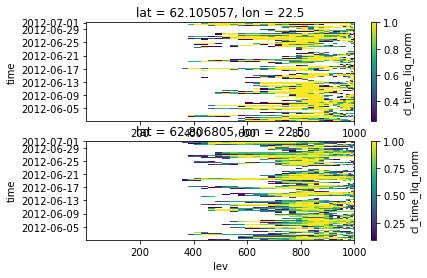

In [236]:
    fig, axs = plt.subplots(2)
    ds2['cl_time_liq_norm'].isel(lat=5, lon=0,
                                    ).plot(ax = axs[0])

    ds2['cl_time_liq_norm'].isel(lat=4, lon=0
                                    ).plot(ax = axs[1])
    plt.show()


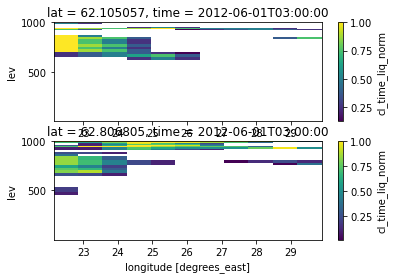

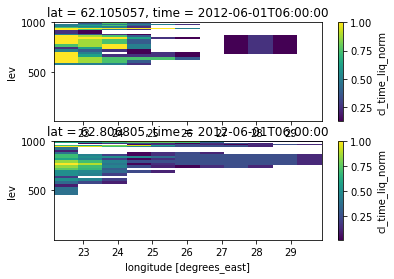

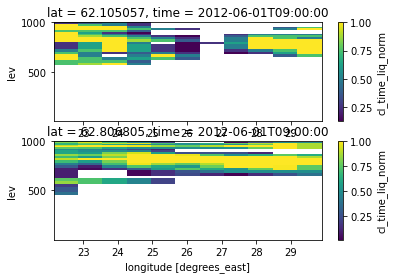

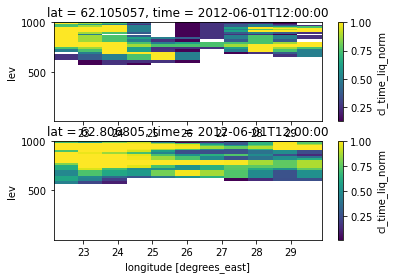

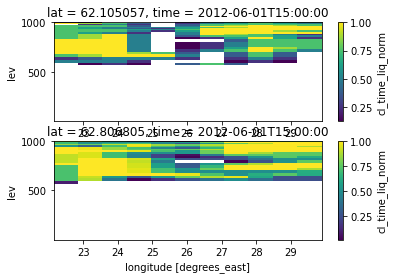

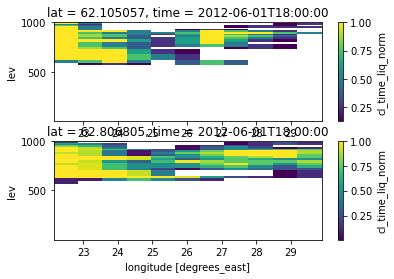

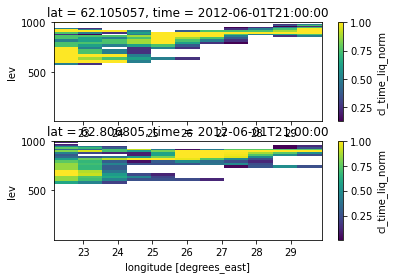

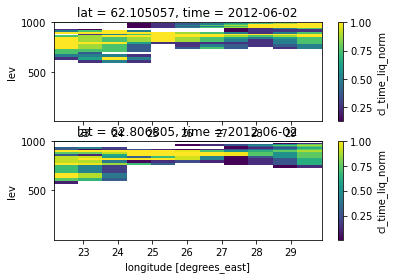

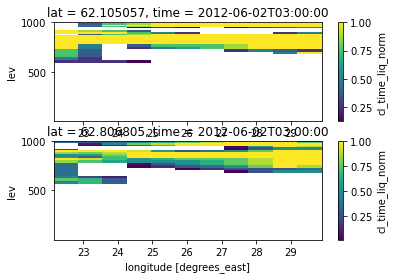

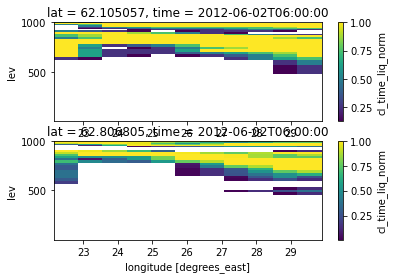

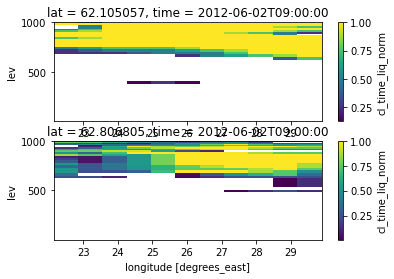

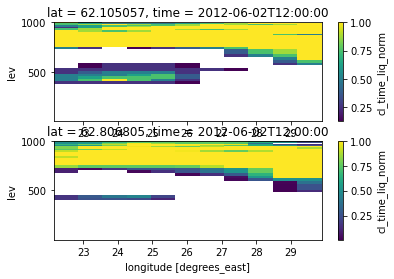

In [237]:
#ds2['cl_frac_where_cltime_pos'].isel(lat=2).mean('time').plot()

#ds2['argmax'].isel(lat=3).std('time').plot()
#ds2['argmax'].isel(lat=4).std('time').plot()
for ti in range(12):
    fig, axs = plt.subplots(2)
    ds2['cl_time_liq_norm'].isel(lat=5, time=ti
                                    ).plot(ax = axs[0])

    ds2['cl_time_liq_norm'].isel(lat=4, time=ti
                                    ).plot(ax = axs[1])
    plt.show()
    #ds2['cl_frac_where_cltime_pos'].isel(lat=6).mean('time').plot()

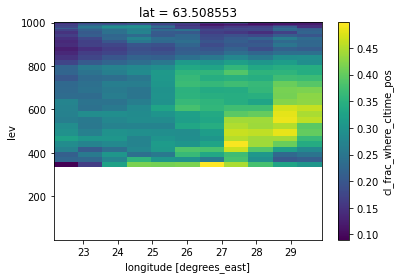

In [218]:
ds2['cl_frac_where_cltime_pos'].isel(lat=3).mean('time').plot()


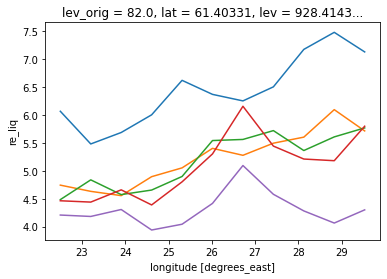

In [ ]:
var = 're_liq'
ds2[var].isel(lat=2, lev=-10).std('time').plot()

ds2[var].isel(lat=3, lev=-10).std('time').plot()
ds2[var].isel(lat=4, lev=-10).std('time').plot()
ds2[var].isel(lat=5, lev=-10).std('time').plot()
ds2[var].isel(lat=6, lev=-10).std('time').plot()

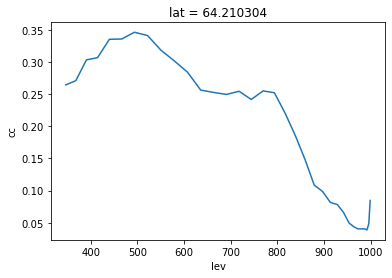

In [186]:
ds2['cc'].where(ds2['liq_cloud_time']>0).isel(lat=2).mean(['lon','time']).plot()#x='lat', ylim=[1e3,100], yscale='log',robust=True)

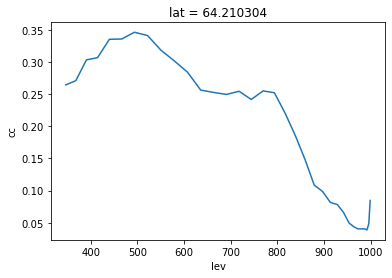

In [186]:
ds2['cc'].where(ds2['liq_cloud_time']>0).isel(lat=2).mean(['lon','time']).plot()#x='lat', ylim=[1e3,100], yscale='log',robust=True)

In [13]:
ds['liq_cloud_time'].max()

<xarray.DataArray 'liq_cloud_time' ()>
array(10800., dtype=float32)

In [14]:
ds['liq_cloud_time'].min()

<xarray.DataArray 'liq_cloud_time' ()>
array(-2.1071244e-12, dtype=float32)

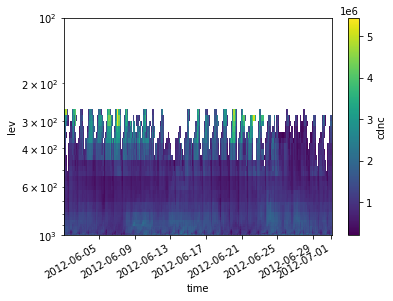

In [15]:
ds['cdnc'].where(ds['liq_cloud_time']>0).mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log')

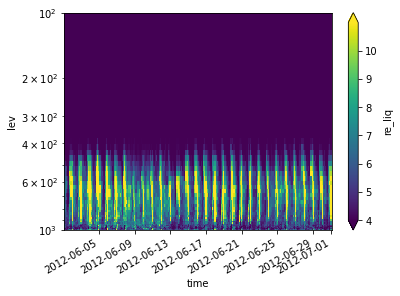

In [16]:
ds['re_liq'].where(ds['re_liq']>0).mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log', robust=True)

In [17]:
ds

<xarray.Dataset>
Dimensions:                   (lev: 91, nhyi: 92, nhym: 91, lat: 10, lon: 22, plev: 11, time: 240)
Coordinates:
    lev_orig                  (lev) float64 1.0 2.0 3.0 4.0 ... 89.0 90.0 91.0
  * lat                       (lat) float32 -1.053 -1.754 ... -6.667 -7.368
  * lon                       (lon) float32 293.2 293.9 294.6 ... 307.3 308.0
  * plev                      (plev) float64 1e+05 9.25e+04 ... 5e+03 1e+03
  * time                      (time) datetime64[ns] 2012-06-01T03:00:00 ... 2...
  * lev                       (lev) float64 0.01 0.0299 0.05684 ... 996.0 998.8
Dimensions without coordinates: nhyi, nhym
Data variables: (12/31)
    hyai                      (nhyi) float64 ...
    hyam                      (nhym) float64 ...
    hybi                      (nhyi) float64 ...
    hybm                      (nhym) float64 0.0 0.0 0.0 ... 0.9959 0.9988
    temp                      (time, plev, lat, lon) float32 ...
    U                         (time, plev, lat, lon) float32 ...
    ...                        ...
    toa_net_lrad_clearclean   (time, lat, lon) float32 ...
    toa_net_lrad_clean        (time, lat, lon) float32 ...
    surf_net_lrad_clearclean  (time, lat, lon) float32 ...
    surf_net_lrad_clean       (time, lat, lon) float32 ...
    tclw                      (time, lat, lon) float32 ...
    tciw                      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Dec 19 23:43:22 2022: ncks -O -d lon,293.0,308.0 -d lat...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [18]:
sec_in_timestep = (3*60*60)

In [83]:
def calculate_incld_values_warmclouds(ds):
    # 3 hourly data: 
    sec_in_timestep = (3*60*60)
    ds['re_liq_incld'] = ((ds['re_liq']/ds['liq_cloud_time'])
                      .where(ds['liq_cloud_time']>0)
                      .where(ds['re_liq']>0)
                      *sec_in_timestep
                     )
    ds['cdnc_incld'] = ((ds['cdnc']/ds['liq_cloud_time'])
                      .where(ds['liq_cloud_time']>0)
                      .where(ds['cdnc']>0)
                      #*(60*60*3)
                     )
    ds['liq_cloud_time_norm'] = ds['liq_cloud_time'].where(ds['liq_cloud_time']>0)/10800
    ds['cc_all'] = ds['cc'].where(ds['cc']>0)
    ds['liq_frac_cwp'] = ds['tclw']/ds['tcw']
    ds['cl_frac_where_cltime_pos'] = ds['cc_all'].where(ds['liq_cloud_time']>0)
    return ds

In [84]:
160/4

40.0

In [85]:
ds = calculate_incld_values_warmclouds(ds)

In [86]:
ds

<xarray.Dataset>
Dimensions:                   (lev: 91, nhyi: 92, nhym: 91, lat: 10, lon: 22, plev: 11, time: 240)
Coordinates:
    lev_orig                  (lev) float64 1.0 2.0 3.0 4.0 ... 89.0 90.0 91.0
  * lat                       (lat) float32 -1.053 -1.754 ... -6.667 -7.368
  * lon                       (lon) float32 293.2 293.9 294.6 ... 307.3 308.0
  * plev                      (plev) float64 1e+05 9.25e+04 ... 5e+03 1e+03
  * time                      (time) datetime64[ns] 2012-06-01T03:00:00 ... 2...
  * lev                       (lev) float64 0.01 0.0299 0.05684 ... 996.0 998.8
Dimensions without coordinates: nhyi, nhym
Data variables: (12/44)
    hyai                      (nhyi) float64 0.0 2.0 3.981 ... 6.576 0.00316 0.0
    hyam                      (nhym) float64 1.0 2.99 5.684 ... 3.289 0.00158
    hybi                      (nhyi) float64 0.0 0.0 0.0 ... 0.9942 0.9976 1.0
    hybm                      (nhym) float64 0.0 0.0 0.0 ... 0.9959 0.9988
    temp                      (time, plev, lat, lon) float32 ...
    U                         (time, plev, lat, lon) float32 ...
    ...                        ...
    cloud_time_norm           (time, lev, lat, lon) float32 0.0 ... -1.879e-16
    argmax                    (time, lat, lon) int64 -26 -27 -26 -1 ... -1 -1 -1
    cdnc_incld_cltop          (time, lat, lon) float32 69.44 90.28 ... nan nan
    re_liq_incld_cltop        (time, lat, lon) float32 8.589 7.345 ... nan nan
    re_liq_cltop              (time, lat, lon) float32 8.589 7.345 ... nan nan
    liq_cloud_time_norm       (time, lev, lat, lon) float32 nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Dec 19 23:43:22 2022: ncks -O -d lon,293.0,308.0 -d lat...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

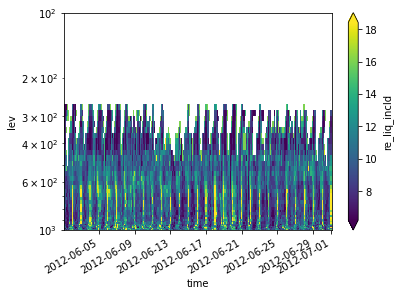

In [87]:
ds['re_liq_incld'].mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log', robust=True,)

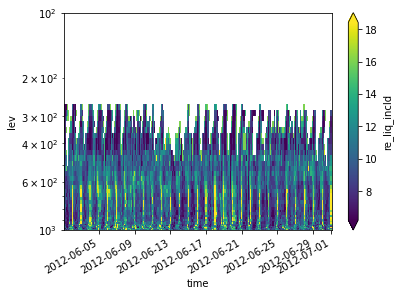

In [88]:
ds['re_liq_incld'].mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log', robust=True,)

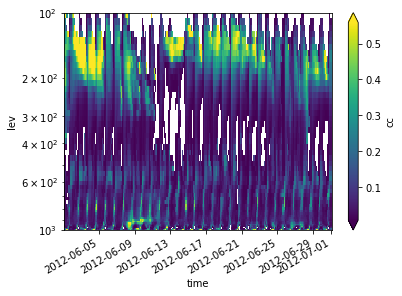

In [89]:
ds['cc'].where(ds['cc']>0).mean(['lat','lon']).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

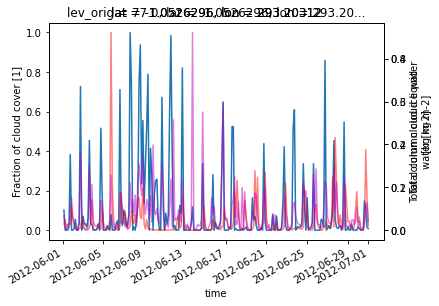

In [90]:
fig, ax = plt.subplots()
ds['cc'].isel(lat=0,lon=0,lev=-15 ).plot()

ds['tciw'].isel(lat=0,lon=0, ).plot(ax = ax.twinx(), c='r',alpha=0.5)
ds['tclw'].isel(lat=0,lon=0, ).plot(ax = ax.twinx(), c='m', alpha=0.5)

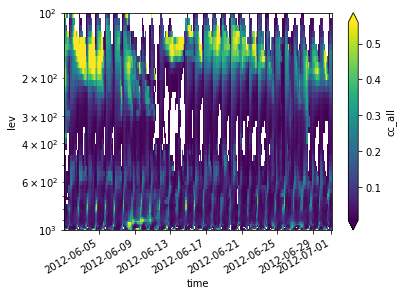

In [91]:
ds['cc_all'].where(ds['cc']>0).mean(['lat','lon']).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

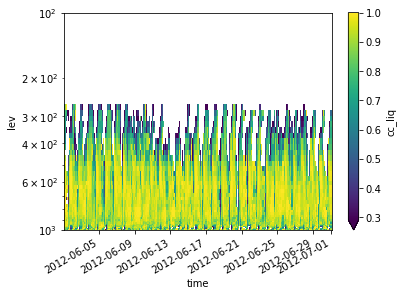

In [92]:
ds['cc_liq'].where(ds['cc']>0).mean(['lat','lon']).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

In [93]:
ds['cc_liq'] = ds['liq_cloud_time'].where(ds['liq_cloud_time']>0)/10800
ds['cc_all'] = ds['cc'].where(ds['cc']>0)

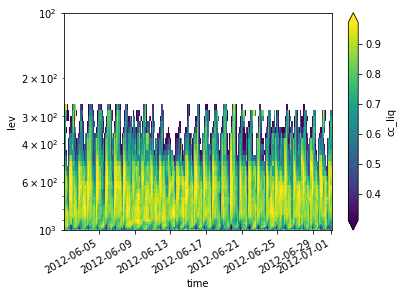

In [94]:
ds['cc_liq'].mean(['lat','lon']).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

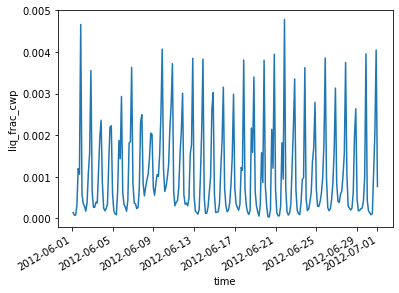

In [28]:
ds['liq_frac_cwp'].mean(['lat','lon']).plot()

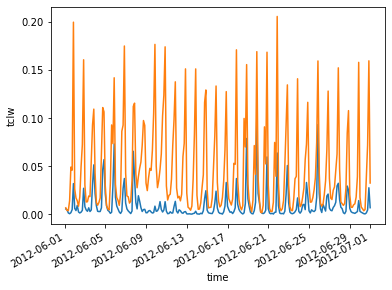

In [29]:
ds['tciw'].mean(['lat','lon']).plot()
ds['tclw'].mean(['lat','lon']).plot()

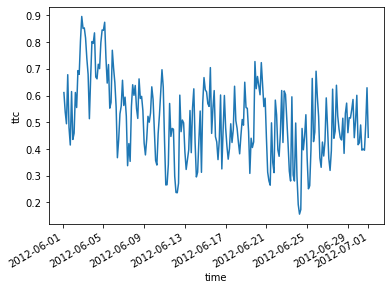

In [30]:
ds['ttc'].mean(['lat','lon']).plot()

Text(0.5, 1.0, 'cc minus cl_time/10800')

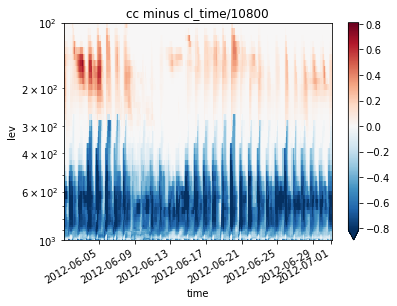

In [31]:
fig, ax = plt.subplots()
(ds['cc_all'].fillna(0)-ds['cc_liq'].fillna(0)).mean(['lat','lon']).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)
#ds['liq_frac_cwp'].mean(['lat','lon']).plot(ax = ax.twinx(),c='m')
plt.title('cc minus cl_time/10800')

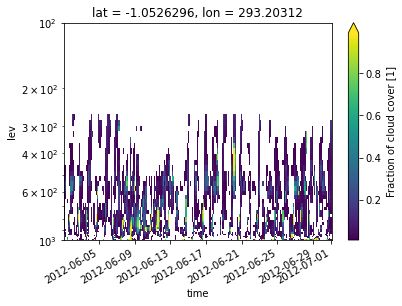

In [32]:
fig, ax = plt.subplots()
(ds['cc_all'].where(ds['cc_liq']>0)).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)
#ds['liq_frac_cwp'].mean(['lat','lon']).plot(ax = ax.twinx(),c='m')
#plt.title('cc minus cl_time/10800')

In [33]:
ds['cl_frac_where_cltime_pos'] = ds['cc_all'].where(ds['cc_liq']>0)

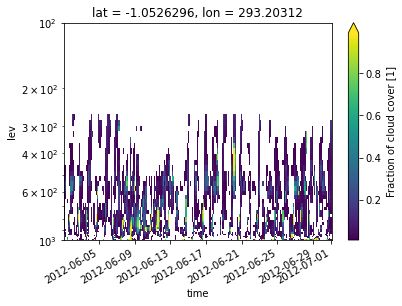

In [34]:
ds['cl_frac_where_cltime_pos'].isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)


In [35]:
60*60*3

10800

In [36]:
sec_in_timestep


10800

In [124]:
def extract_cloud_top(ds):
    if 'lev_orig' not in ds.coords:
        ds = make_dummy_lev(ds)
    ds = ds.sortby('lev', ascending=False)
    
    ds['cl_frac_where_cltime_pos'] = ds['cc_all'].where(ds['cc_liq']>0)
    ds['cumsum'] = (ds['cl_frac_where_cltime_pos']
                    .cumsum('lev')
                    .where(ds['cc_liq']>0)
                   )#)
    ds['cloud_time_norm'] = ds['liq_cloud_time']/sec_in_timestep
    ds['cumsum'] = ds['cumsum'].where(ds['cloud_time_norm']>0)
    ds['cumsum'] = ds['cumsum'].where(ds['cloud_time_norm']==1.)
    ds['cumsum'] = ds['cumsum'].where(ds['cl_frac_where_cltime_pos']>.2)
    #ds['cumsum'] = ds['cumsum'].where(np.abs(ds['re_liq']-4)>.01)
    ds['argmax'] = ds['cumsum'].fillna(0).argmax('lev',)
    ds['argmax'] = ds['argmax']
    
    ds['cdnc_incld_cltop'] = ds['cdnc_incld'].isel(lev = ds['argmax']).where(ds['argmax']>0)
    ds['re_liq_incld_cltop'] = ds['re_liq_incld'].isel(lev = ds['argmax']).where(ds['argmax']>0)
    ds['re_liq_cltop'] = (ds['re_liq']
                          .where(ds['cl_frac_where_cltime_pos']>0)
                          .isel(lev = ds['argmax']).where(ds['argmax']>0)
                         )
    
    ds = ds.sortby('lev', ascending=True)
    ds['argmax'] = -ds['argmax']-1

    return ds

In [125]:
ds = extract_cloud_top(ds)

(array([355076.,  53117.,  23860.,  11911.,   7535.,   5118.,   3730.,
          3419.,   2852.,  10779.]),
 array([0.0078125 , 0.10703125, 0.20625   , 0.30546874, 0.4046875 ,
        0.50390625, 0.603125  , 0.70234376, 0.8015625 , 0.9007813 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

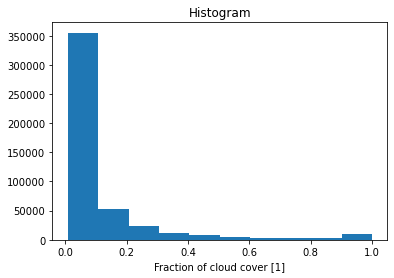

In [126]:
ds['cl_frac_where_cltime_pos'].plot()

In [127]:
import numpy as np

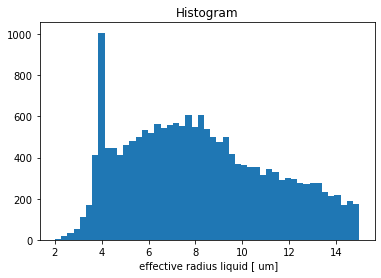

In [129]:
ds['re_liq_cltop'].plot(bins=np.linspace(2,15));


(1000.0, 300.0)

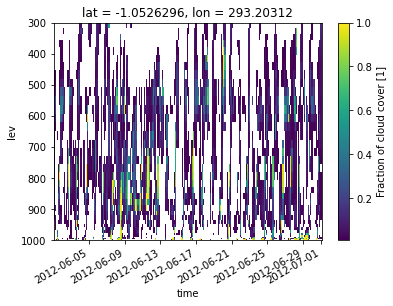

In [130]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['cl_frac_where_cltime_pos'].isel(lat=0,lon=0).plot(x='time',)#  ylim=[1e3,100], yscale='log', robust=True,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']>0).isel(lat=0,lon=0).plot(c='r')
plt.ylim([1e3,300])

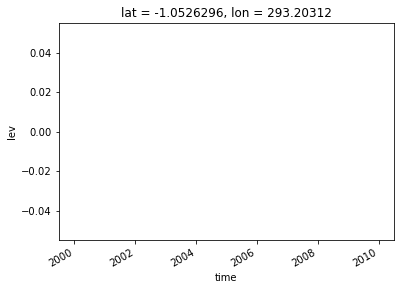

In [131]:
ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']>0).isel(lat=0,lon=0).plot(c='r', marker='.')


(1000.0, 300)

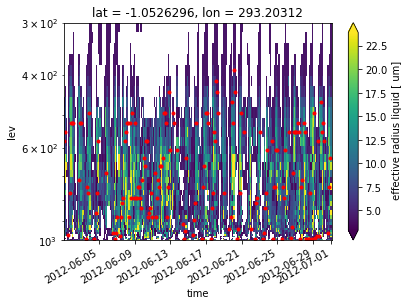

In [132]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['re_liq'].where(ds['liq_cloud_time']>0).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']<-1).isel(lat=0,lon=0).plot(c='r', marker='.', linewidth=0)
plt.ylim([1e3,300])

(1000.0, 300)

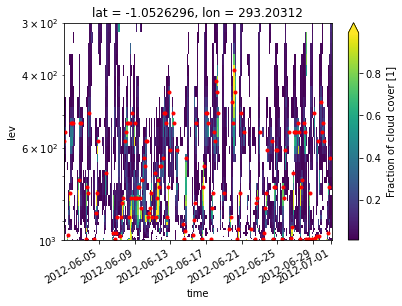

In [ ]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['cl_frac_where_cltime_pos'].where(ds['liq_cloud_time']>0).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']<-1).isel(lat=0,lon=0).plot(c='r', marker='.', linewidth=0)
plt.ylim([1e3,300])

(1000.0, 300)

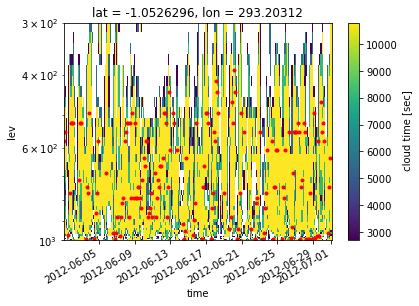

In [106]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['liq_cloud_time'].where(ds['liq_cloud_time']>0).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']<-1).isel(lat=0,lon=0).plot(c='r', marker='.', linewidth=0)
plt.ylim([1e3,300])

(1000.0, 300)

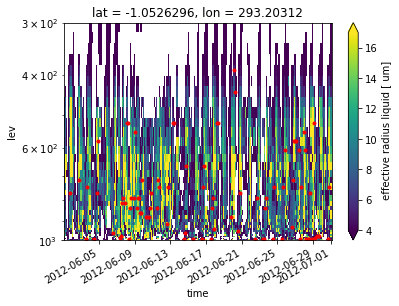

In [46]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['re_liq'].where(ds['liq_cloud_time']>0).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log',vmin=4,vmax=17,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']<-1).isel(lat=0,lon=0).plot(c='r', marker='.', linewidth=0)
plt.ylim([1e3,300])

(1000.0, 300)

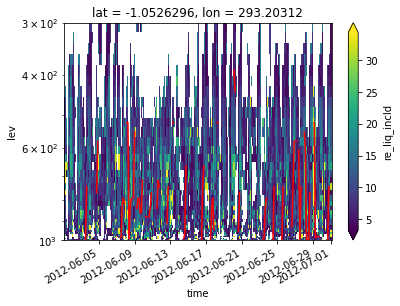

In [47]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['re_liq_incld'].isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']<-1).isel(lat=0,lon=0).plot(c='r')
plt.ylim([1e3,300])

(1000.0, 300)

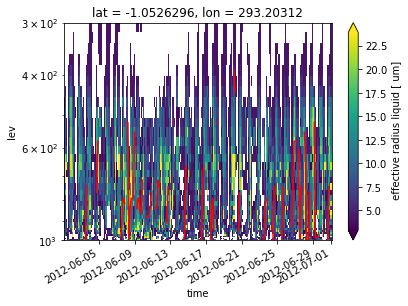

In [48]:
fig, ax = plt.subplots()
#ds['cumsum'] = ds['cl_frac_where_cltime_pos'].cumsum('dummy_lev').where(ds['cc_liq']>0)#
ds['re_liq'].where(ds['liq_cloud_time']>0).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)

ds['lev'].isel(lev = ds['argmax']).where(ds['argmax']<-1).isel(lat=0,lon=0).plot(c='r')
plt.ylim([1e3,300])

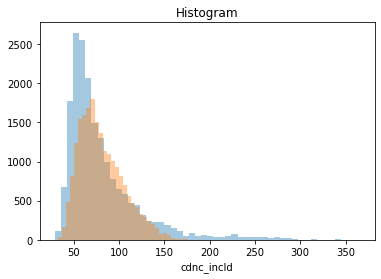

In [517]:
ds['cdnc_incld_cltop'].plot.hist(alpha=.4, bins=50)
ds['cdnc_incld'].mean('lev').plot.hist(alpha=.4, bins=50);

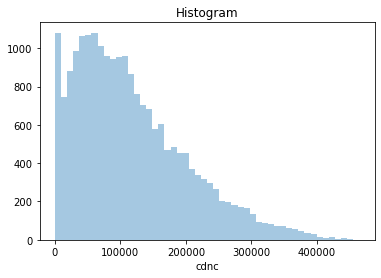

In [374]:
ds['cdnc'].mean('dummy_lev').plot.hist(alpha=.4, bins=50);

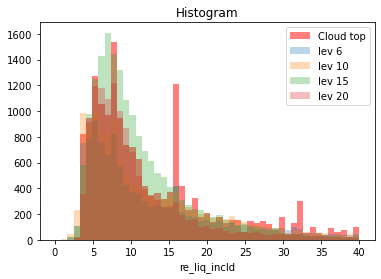

In [520]:
ds['re_liq_incld_cltop'].plot.hist(alpha=.5, bins=np.linspace(0,40), label ='Cloud top', color='r');

ds['re_liq_incld'].isel(lev=-6).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 6' );
ds['re_liq_incld'].isel(lev=-10).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 10');
ds['re_liq_incld'].isel(lev=-15).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 15');
ds['re_liq_incld'].isel(lev=-20).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 20');
plt.legend()


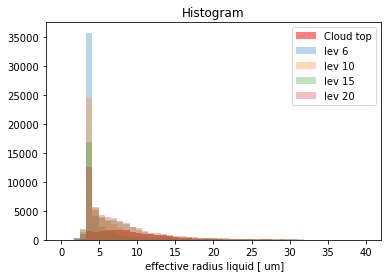

In [138]:
ds['re_liq_cltop'].plot.hist(alpha=.5, bins=np.linspace(0,40), label ='Cloud top', color='r');

ds['re_liq'].isel(lev=-6).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 6' );
ds['re_liq'].isel(lev=-10).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 10');
ds['re_liq'].isel(lev=-15).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 15');
ds['re_liq'].isel(lev=-20).plot.hist(alpha=.3, bins=np.linspace(0,40), label ='lev 20');
plt.legend()


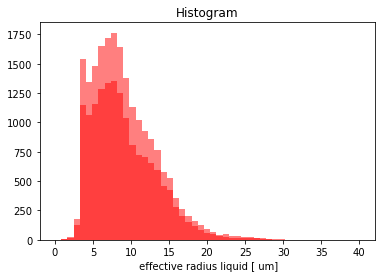

In [144]:
ds['re_liq_cltop'].plot.hist(alpha=.5, bins=np.linspace(0,40), label ='Cloud top', color='r');


ds['re_liq_cltop'].where((ds['tclw']/(ds['tciw']+ds['tclw']))>.8).plot.hist(alpha=.5, bins=np.linspace(0,40), label ='Cloud top', color='r');


(array([4.100e+01, 1.630e+02, 4.830e+02, 8.170e+02, 1.237e+03, 1.542e+03,
        1.596e+03, 1.682e+03, 1.795e+03, 1.503e+03, 1.362e+03, 1.140e+03,
        1.098e+03, 1.008e+03, 9.280e+02, 8.130e+02, 7.020e+02, 5.560e+02,
        4.740e+02, 4.140e+02, 3.310e+02, 2.870e+02, 2.400e+02, 2.060e+02,
        1.460e+02, 7.800e+01, 8.400e+01, 6.100e+01, 3.000e+01, 1.500e+01,
        6.000e+00, 1.000e+01, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 32.6423  ,  37.107174,  41.572044,  46.03692 ,  50.501793,
         54.966667,  59.431538,  63.89641 ,  68.36128 ,  72.82616 ,
         77.29103 ,  81.755905,  86.22078 ,  90.68565 ,  95.15052 ,
         99.615395, 104.08027 , 108.54514 , 113.01002 , 117.47489 ,
        121.93976 , 126.40463 , 130.8695  , 135.33438 , 139.79926 ,
        144.26413 , 148.729   , 153.

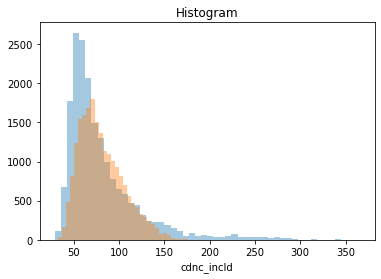

In [521]:
ds['cdnc_incld_cltop'].plot.hist(alpha=.4, bins=50)
ds['cdnc_incld'].mean('lev').plot.hist(alpha=.4, bins=50)

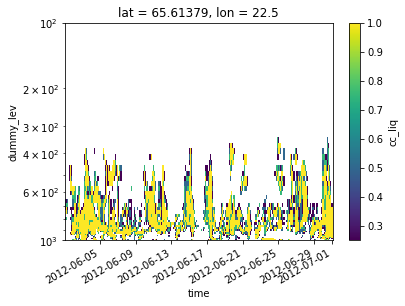

In [234]:
fig, ax = plt.subplots()
(ds['cc_liq'].where(ds['cc_liq']>0)).isel(lat=0,lon=0).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)
#ds['liq_frac_cwp'].mean(['lat','lon']).plot(ax = ax.twinx(),c='m')
#plt.title('cc minus cl_time/10800')

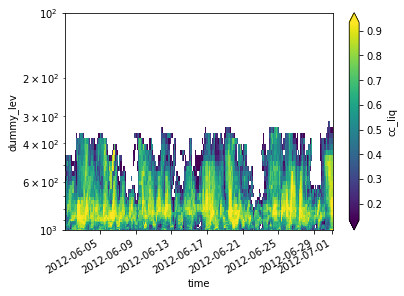

In [232]:
fig, ax = plt.subplots()
(ds['cc_liq'].where(ds['cc_liq']>0)).mean(['lat','lon']).plot(x='time',  ylim=[1e3,100], yscale='log', robust=True,)
#ds['liq_frac_cwp'].mean(['lat','lon']).plot(ax = ax.twinx(),c='m')
#plt.title('cc minus cl_time/10800')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


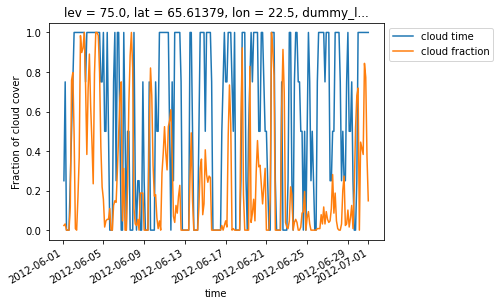

In [206]:
ds['cc_liq'].fillna(0).sel(dummy_lev = 800, method='nearest').isel(lat=0,lon=0).plot(label='cloud time')#linewidth=0, marker='.')

ds['cc'].sel(dummy_lev = 800, method='nearest').isel(lat=0,lon=0).plot(label='cloud fraction')#linewidth=0, marker='.')

plt.legend(bbox_to_anchor=(1,1,))

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


(array([ 80364.,      0.,  31426.,      0.,      0.,  49398.,      0.,
         49666.,      0., 164025.]),
 array([-1.9232011e-16,  1.0000000e-01,  2.0000000e-01,  3.0000001e-01,
         4.0000001e-01,  5.0000000e-01,  6.0000002e-01,  6.9999999e-01,
         8.0000001e-01,  8.9999998e-01,  1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

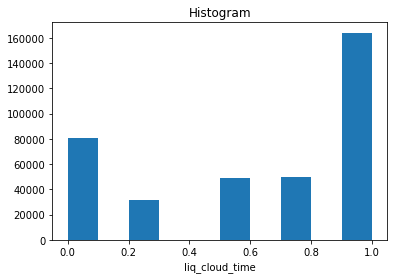

In [212]:
(ds['liq_cloud_time']/10800).sel(dummy_lev = 800, method='nearest').isel(lat=0,lon=0).where(ds['liq_cloud_time']>0).plot()

In [225]:
df = (ds['liq_cloud_time']).sel(dummy_lev = 800, method='nearest').isel(lat=0,lon=0).where(ds['liq_cloud_time']>0).to_dataframe()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


In [229]:
df['liq_cloud_time'].where(df['liq_cloud_time']>0).unique()

array([   nan,  2700.,  8100.,  5400., 10800.], dtype=float32)

In [220]:
(10800/4)/60

45.0

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


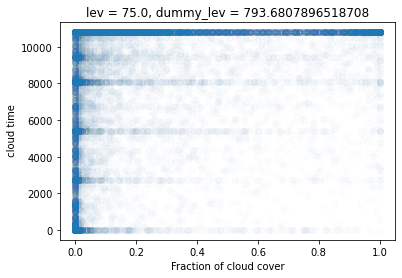

In [199]:
ds.sel(dummy_lev = 800, method='nearest').plot.scatter(x='cc',y='liq_cloud_time', alpha=0.01)

In [166]:
import numpy as np

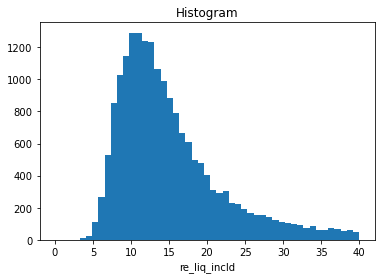

In [167]:
(ds['re_liq_incld'].mean('dummy_lev')).plot.hist(bins=np.linspace(0,40));

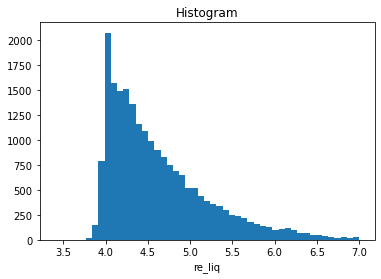

In [265]:
(ds['re_liq'].mean('dummy_lev')).plot.hist(bins=np.linspace(3.4,7));

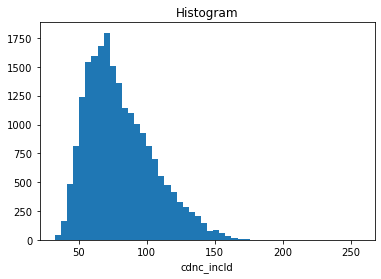

In [168]:
(ds['cdnc_incld'].mean('dummy_lev')).plot.hist(bins=50);#bins=np.linspace(0,.004));

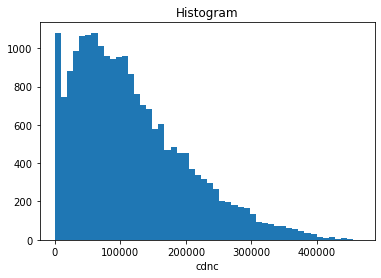

In [170]:
ds['cdnc'].mean('dummy_lev').plot.hist(bins=50);#bins=np.linspace(0,.004));

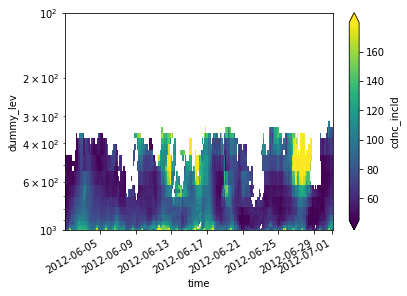

In [171]:
ds['cdnc_incld'].mean(['lat','lon']).plot(x='time', ylim=[1e3,100], yscale='log', robust=True)

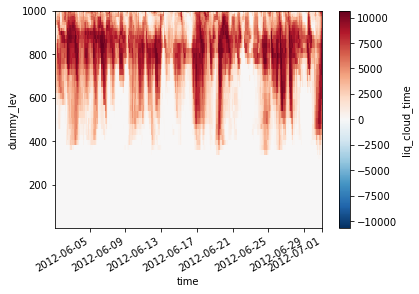

In [172]:
ds['liq_cloud_time'].mean(['lat','lon']).plot(x='time', )